In [ ]:
!pip install --upgrade pip
!pip install --upgrade datasets[audio] transformers accelerate evaluate jiwer tensorboard gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 110.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 126.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 MB 57.9 MB/s  0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 93.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 65.4 MB/s  0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: gradio-client
    Found existing installation: gradio_client 1.11.1
    Uninstalling gradio_client-1.11.1:
      Successfully uninstalled gradio_client-1.11.1
  Attempting uninstall: transformers
    Found

In [ ]:
#!pip install librosa soundfile ffmpeg-python

In [ ]:
import json
import os
from datasets import Dataset, Audio
import torchaudio
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/..."

In [ ]:
# Charger le dictionnaire dico_corpus.json
with open(path + '/dico_corpus.json', 'r') as f:
  dico_corpus = json.load(f)

###Construction d’une liste d’enregistrements

In [ ]:
records = []
for idx, meta in dico_corpus.items():
    folder = f"{path}/{meta['identifiant']}"
    # parcourir tous les fichiers .wav (ou .mp3) dans le dossier
    for fname in os.listdir(folder):
        if fname.endswith(('.wav', '.flac', '.mp3', '.webm')):
            records.append({
                "audio": os.path.join(folder, fname),
                "text": meta['contenu']
            })


### Création du Dataset

In [ ]:
# Créer le dataset à partir de la liste
ds = Dataset.from_list(records)
test_ds = Dataset.from_list(test_records)
# Indiquer que la colonne "audio" contient des fichiers audio
#ds = ds.cast_column("audio", Audio(sampling_rate=16_000))

In [ ]:
ds

Dataset({
    features: ['audio', 'text'],
    num_rows: 160
})

In [ ]:
test_ds

Dataset({
    features: ['audio', 'text'],
    num_rows: 17
})

### Speech Processing

In [ ]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained(
    "openai/whisper-small",
    language="fr",       # si vos données sont en français
    task="transcribe"    # transcription seule
)
# WhisperProcessor = WhisperFeatureExtractor + WhisperTokenizer
# En effet, l'Extractor transforme les audio en log mel(spectogramme) et le Tokenizer pour tokenizer les labels

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

In [ ]:
import torchaudio

def prepare_batch(batch):
    try:
        waveform, sr = torchaudio.load(batch["audio"])  # sr détecté automatiquement
        if sr != 16000:
            waveform = torchaudio.functional.resample(waveform, sr, 16000)

        # waveform est Tensor [1, T]
        audio = waveform.squeeze().numpy()
        inputs = processor(audio, sampling_rate=16000, return_tensors="pt")

        # Créer le masque d'attention
        attention_mask = torch.ones_like(inputs.input_features) # Masque initial tout à 1
        attention_mask = attention_mask.masked_fill(inputs.input_features.eq(0), 0) # Mettre à 0 les positions de padding

        # Tokenization des labels
        labels = processor.tokenizer(batch["text"], return_tensors="pt").input_ids

        return {
            "input_features": inputs.input_features[0],
            "attention_mask": attention_mask[0],
            "labels": labels[0]
        }

    except Exception as e:
        print(f"[ERREUR] Fichier problématique: {batch['audio']}")
        print(f"Exception: {type(e).__name__} — {e}")
        return None

ds_prepared = ds.map(
    prepare_batch,
    remove_columns=["audio", "text"],
    num_proc=1
)
test_ds_prepared = test_ds.map(
    prepare_batch,
    remove_columns=["audio", "text"],
    num_proc=1
)

# Enlever les valeurs None du dataset
ds_prepared = ds_prepared.filter(lambda example: example is not None)

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

Filter:   0%|          | 0/160 [00:00<?, ? examples/s]

In [ ]:
ds_prepared

Dataset({
    features: ['input_features', 'attention_mask', 'labels'],
    num_rows: 160
})

In [ ]:
test_ds_prepared

Dataset({
    features: ['input_features', 'attention_mask', 'labels'],
    num_rows: 17
})

In [ ]:
from datasets import DatasetDict

# Split: 90% train, 10% test
split_dataset = ds_prepared.train_test_split(test_size=0.1, seed=42)

# Organiser sous forme de DatasetDict
ds_prepared = DatasetDict({
    "train": split_dataset["train"],
    "test": split_dataset["test"]
})

# Afficher un petit résumé
print(ds_prepared)

DatasetDict({
    train: Dataset({
        features: ['input_features', 'attention_mask', 'labels'],
        num_rows: 144
    })
    test: Dataset({
        features: ['input_features', 'attention_mask', 'labels'],
        num_rows: 16
    })
})


In [ ]:
for i in range(3):
    print(f"--- Sample {i} ---")
    print("Input shape:", len(ds_prepared['train'][i]["input_features"]))
    print("Label IDs:", ds_prepared['train'][i]["labels"])

--- Sample 0 ---
Input shape: 80
Label IDs: [50258, 50363, 38742, 15735, 882, 696, 4397, 1004, 12, 3474, 41053, 3780, 621, 13, 198, 47, 296, 368, 3928, 259, 27212, 414, 2104, 66, 17638, 2879, 368, 635, 598, 31387, 730, 13121, 2156, 13, 198, 47, 296, 274, 913, 247, 30466, 12401, 1563, 526, 1771, 12, 14645, 4198, 1220, 2411, 198, 25597, 526, 861, 5066, 730, 8265, 705, 19126, 36321, 12, 446, 299, 425, 10840, 13, 198, 33274, 1043, 368, 635, 923, 20596, 7623, 3003, 405, 438, 368, 287, 6, 16171, 1459, 306, 13, 220, 50257]
--- Sample 1 ---
Input shape: 80
Label IDs: [50258, 50363, 35, 5606, 81, 22279, 795, 9384, 541, 287, 3548, 9020, 1531, 42432, 5066, 36724, 13, 198, 47, 296, 368, 8023, 405, 518, 6509, 526, 32728, 3867, 274, 913, 247, 526, 2635, 313, 730, 5924, 7511, 6509, 526, 6198, 2449, 13, 198, 33274, 1043, 1581, 5257, 6509, 526, 32728, 2183, 24608, 13, 198, 47, 1236, 518, 728, 12, 3281, 526, 32728, 441, 19, 12, 43, 20, 13, 198, 47, 296, 274, 913, 247, 555, 526, 29087, 975, 13, 198, 3327

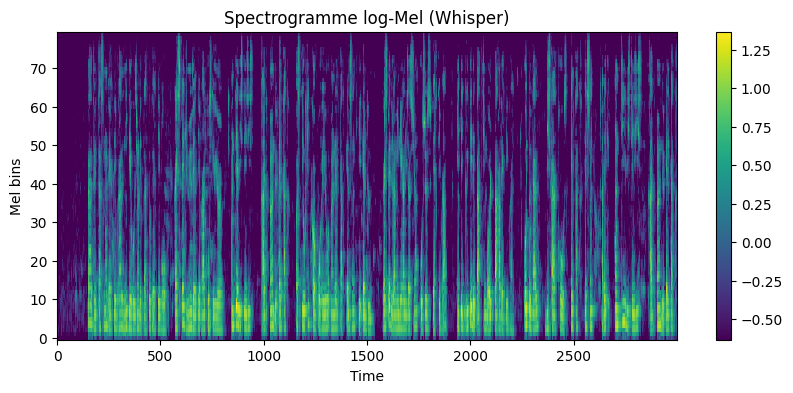

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

features = ds_prepared['train'][90]["input_features"]
plt.figure(figsize=(10, 4))
plt.imshow(np.array(features), aspect="auto", origin="lower", interpolation="none")
plt.title("Spectrogramme log-Mel (Whisper)")
plt.xlabel("Time")
plt.ylabel("Mel bins")
plt.colorbar()
plt.show()

### Fine Tuning

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained(
    "openai/whisper-small"
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

In [ ]:
model.generation_config.language = "fr"
model.generation_config.task = "transcribe"

model.generation_config.forced_decoder_ids = [[1, None], [2, 50359]] #None

In [ ]:
"""
# decoder_start_token_id
C’est un token spécial que le modèle doit recevoir au tout début de la séquence cible pendant l'entraînement.
Sans ce token de démarrage, le modèle ne saura pas où commencer la génération lors du décodage.

Il faut un ajout explicite du decoder_start_token_id au début de la séquence cible.
"""

"\n# decoder_start_token_id\nC’est un token spécial que le modèle doit recevoir au tout début de la séquence cible pendant l'entraînement.\nSans ce token de démarrage, le modèle ne saura pas où commencer la génération lors du décodage.\n\nIl faut un ajout explicite du decoder_start_token_id au début de la séquence cible.\n"

In [ ]:
import torch
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int
    max_audio_len: int = 30 * 16000  # 30s at 16kHz
    max_label_len: int = 448

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # -------- Audio --------
        # input_features = []
        # for feature in features:
        #     x = feature["input_features"]

        #     # trim or pad to 30 seconds (480_000 samples for Whisper)
        #     if x.shape[-1] > self.max_audio_len:
        #         x = x[..., :self.max_audio_len]
        #     elif x.shape[-1] < self.max_audio_len:
        #         pad_width = self.max_audio_len - x.shape[-1]
        #         x = torch.nn.functional.pad(x, (0, pad_width))
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # -------- Labels --------
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # Truncate labels to max_label_len
        labels = labels[:, :self.max_label_len]

        # Retirer le token de début s’il est déjà là, car Whisper l’ajoute pendant la génération
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        # Ajouter manuellement le decoder_start_token_id
        decoder_start_tokens = torch.full((labels.size(0), 1), self.decoder_start_token_id, dtype=torch.long)
        labels = torch.cat([decoder_start_tokens, labels], dim=1)

        batch["labels"] = labels

        return batch


In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

Evaluation

In [ ]:
import evaluate

metric = evaluate.load("wer")

In [ ]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [ ]:
# Geler l'encodeur
for param in model.model.encoder.parameters():
       param.requires_grad = False

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-rad-fr",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    eval_strategy="steps",
    eval_steps=500,
    save_steps=1000,
    warmup_steps=500,
    max_steps=5000,
    predict_with_generate=True,
    generation_max_length=225,
    gradient_checkpointing=True,
    learning_rate=3e-5,
    num_train_epochs=3,
    fp16=True,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,

)

from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=ds_prepared["train"],
    eval_dataset=ds_prepared["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    processing_class=processor.feature_extractor,
)


trainer.train()


You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...


Step,Training Loss,Validation Loss,Wer
500,0.013200,1.088975,56.265060
1000,0.000100,1.192919,45.421687
1500,0.000000,1.202546,44.698795
2000,0.000000,1.216908,45.180723
2500,0.000000,1.244911,44.578313
3000,0.000000,1.260206,44.337349
3500,0.000000,1.274711,44.337349


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3922: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because yo